Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)

Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей

Построить случайный лес, вывести важность признаков

Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии

Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
В качестве решения: Jupyter notebook с кодом, комментариями и графиками, ссылка на гитхаб

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np

import time
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import mplcyberpunk
from pylab import rcParams

from stacking import StackModel

In [2]:
data = pd.read_csv('train.csv')

In [3]:
pd.set_option('display.max_columns', None)
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

In [4]:
data['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [5]:
data[data.MasVnrArea.isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,235,60,RL,NaN,7851,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,216500
529,530,20,RL,NaN,32668,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Alloca,200624
650,651,60,FV,65.0,8125,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,205950
936,937,20,RL,67.0,10083,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,2003.0,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal,184900
973,974,20,FV,95.0,11639,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2007.0,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,NaN,NaN,NaN,0,12,2008,New,Partial,182000
977,978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,NaN,Attchd,2007.0,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,NaN,NaN,NaN,0,11,2007,New,Partial,199900
1243,1244,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,NaN,NaN,NaN,0,9,2006,New,Partial,465000
1278,1279,60,RL,75.0,9473,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804,Unf,0,324,1128,GasA,Ex,Y,SBrkr,1128,903,0,2031,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2,577,TA,TA,Y,0,211,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal,237000


In [6]:
del(data['Id'])


def ohe(data, cols):
    for col in cols:
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)
        del(data[col])
    
    return data


# columns for one hot encoding
cols = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
        'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
data = ohe(data, cols)


def air(val):
    if val == 'Y':
        return 1
    else:
        return 0

data['CentralAir'] = data['CentralAir'].apply(air)


# convert date to timestamp
def dt(row):
    s = "{:.0f} {:.0f}".format(row['MoSold'], row['YrSold'])
    return time.mktime(datetime.datetime.strptime(s, "%m %Y").timetuple())


data['timestamp'] = data.apply(dt, axis=1)
del(data['MoSold'])
del(data['YrSold'])

In [7]:
X = data.copy()
del(X['SalePrice'])
y = data['SalePrice']

In [8]:
# NA finder

def find_na(row):
    for key in row.keys():
        if pd.isna(row[key]):
            print(f'Nan value on {key}')

X.apply(find_na, axis=1)

Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on GarageYrBlt
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on GarageYrBlt
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on GarageYrBlt
Nan value on LotFrontage
Nan value on GarageYrBlt
Nan value on GarageYrBlt
Nan value on LotFrontage
Nan value on GarageYrBlt
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on GarageYrBlt
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on GarageYrBlt
Nan value on LotFrontage
Nan value on GarageYrBlt
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on GarageYrBlt
Nan value on LotFrontage
Nan value on GarageYrBlt
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on GarageYrBlt


Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on LotFrontage
Nan value on GarageYrBlt
Nan value on GarageYrBlt
Nan value on GarageYrBlt


0       None
1       None
2       None
3       None
4       None
        ... 
1455    None
1456    None
1457    None
1458    None
1459    None
Length: 1460, dtype: object

In [9]:
lotfront = data['LotFrontage'].mean()

def fill_na(na):
    global lotfront
    if pd.isna(na):
        return lotfront
    else:
        return na
    
X['LotFrontage'] = X['LotFrontage'].apply(fill_na)

In [10]:
def fill_garage_year(row):
    if pd.isna(row['GarageYrBlt']):
        return row['YearBuilt']
    else:
        return row['GarageYrBlt']

X['GarageYrBlt'] = X.apply(fill_garage_year, axis=1)

In [11]:
X.fillna(0, inplace=True)

In [12]:
model = RandomForestRegressor(n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
p = model.predict(X_test)

### random forest score

In [13]:
r2_score(y_test, p)

0.8858474936025282

In [14]:
mean_squared_error(y_test, p)

875586961.4366238

In [15]:
rcParams['figure.figsize'] = 20, 10

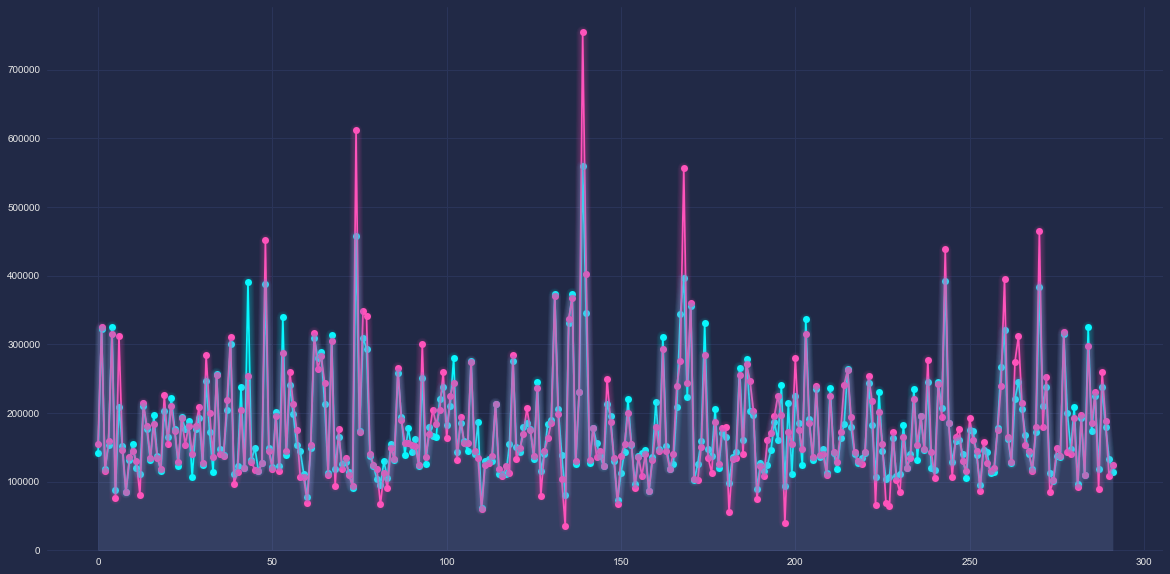

In [16]:
plt.style.use("cyberpunk")

plt.plot(p, marker='o')
plt.plot(y_test.values, marker='o')

mplcyberpunk.add_glow_effects()

plt.show()

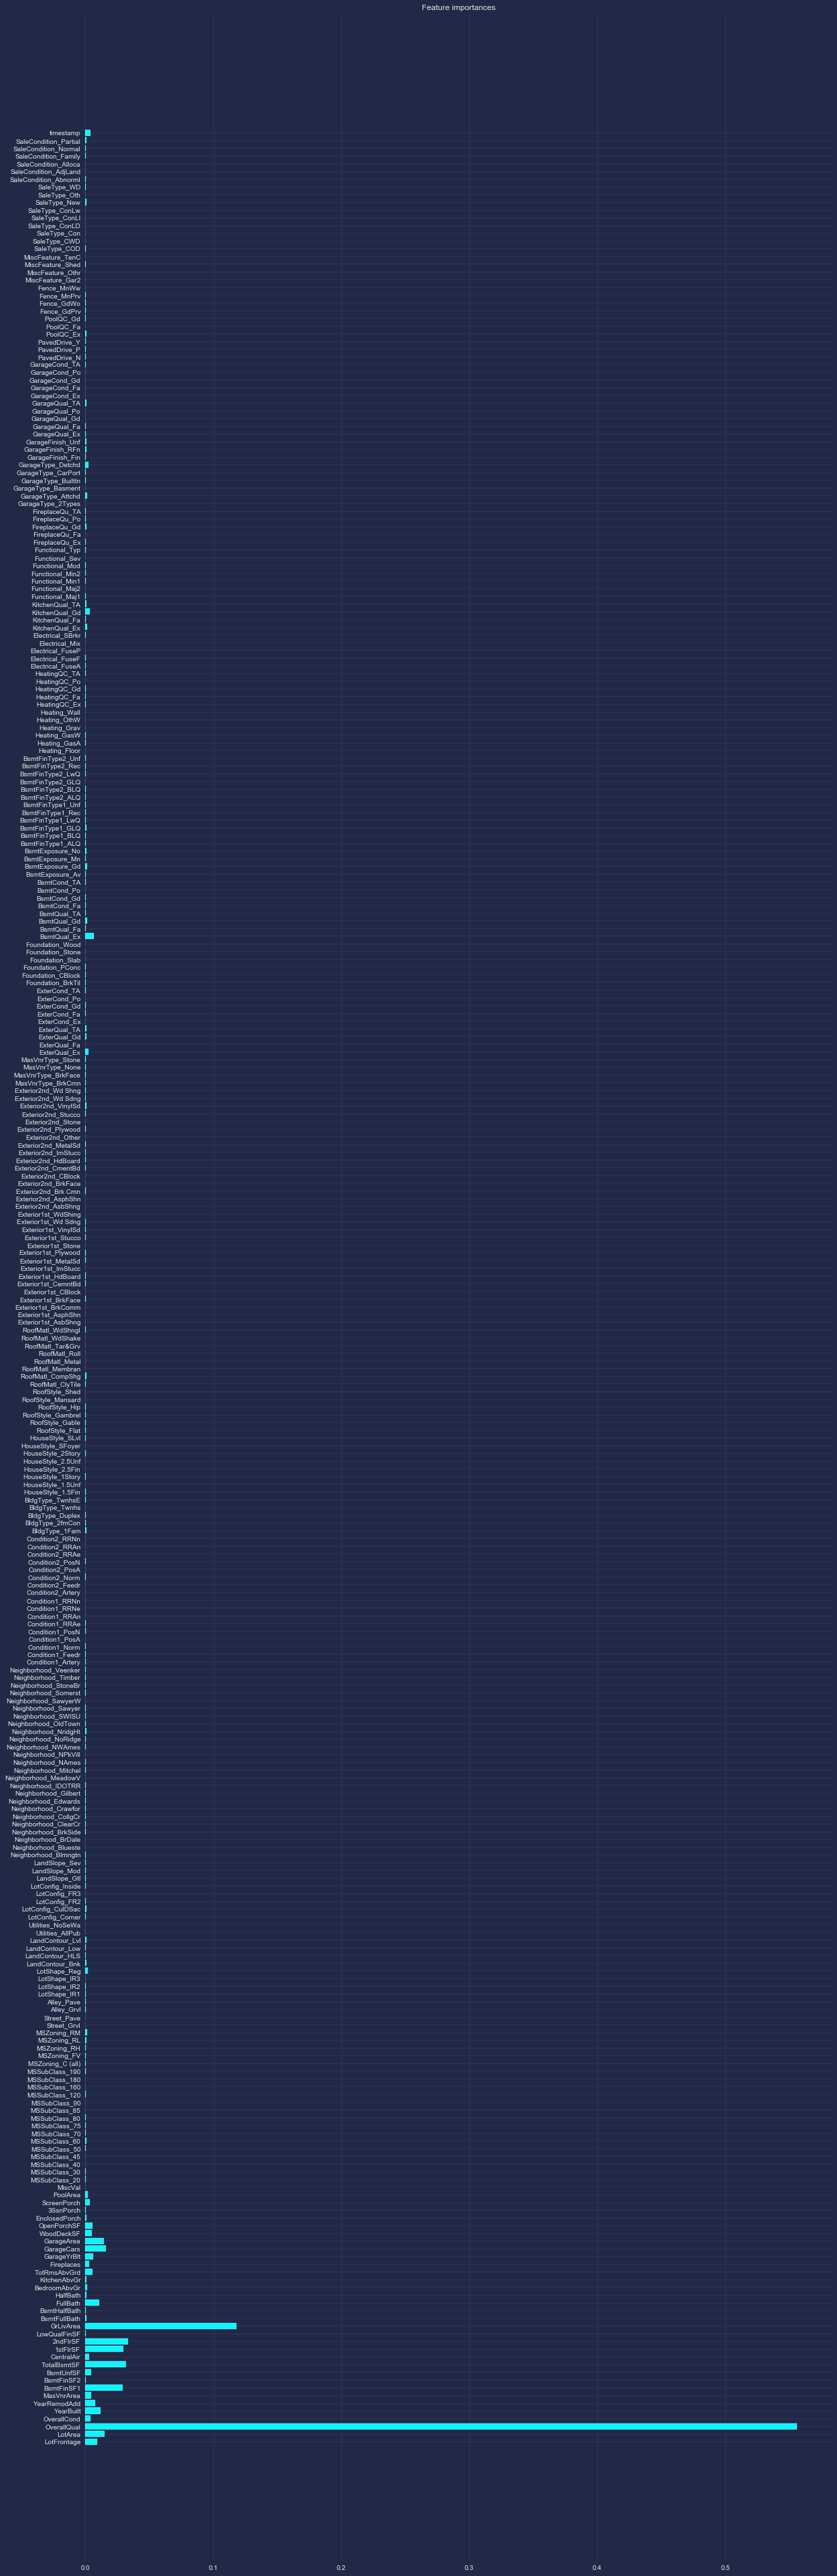

In [17]:
importance = model.feature_importances_
rcParams['figure.figsize'] = 20, 70
plt.style.use("cyberpunk")
plt.figure()
plt.title("Feature importances")
plt.barh(X.columns, importance)

plt.show()

K-fold validation

In [18]:
kf = KFold(n_splits=10)
i = 0

for train, test in kf.split(X):
    i+=1
    X_train, X_test = X.values[train], X.values[test]
    y_train, y_test = y.values[train], y.values[test]
    
    model.fit(X_train, y_train)
    p = model.predict(X_test)
    
    print(f'Fold #{i} R2 score: ', r2_score(y_test, p))

Fold #1 R2 score:  0.8675676447917955
Fold #2 R2 score:  0.8914962355549326
Fold #3 R2 score:  0.9231279646110444
Fold #4 R2 score:  0.7503434229502668
Fold #5 R2 score:  0.8825589044559359
Fold #6 R2 score:  0.8840932242229039
Fold #7 R2 score:  0.8918383183307201
Fold #8 R2 score:  0.8855771031481849
Fold #9 R2 score:  0.8101919621785454
Fold #10 R2 score:  0.8615274690768833


A solid result.

# Handmade stacking realization
For stacking I use my own realization, which can be seen in stacking.py.

In [19]:
# split data for learn week models and meta model
X_week, X_holdout, y_week, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# week models
models = [LinearRegression(), KNeighborsRegressor(n_neighbors=3), GaussianProcessRegressor(normalize_y=True)]

stack = StackModel(models, LinearRegression(), 10)

In [21]:
stack.fit(X_week, y_week)

In [24]:
p = stack.predict(X_holdout, y_holdout)

In [25]:
stack.estimators_score

{'LinearRegression': 0.35613079505752365,
 'KNeighborsRegressor': 0.27627656462873473,
 'GaussianProcessRegressor': -0.0007247665049872065}

Models are really week :) Last one is worse than if we just always use mean value as our prediction.

In [26]:
r2_score(y_holdout, p)

0.5515836712740401

This one is much better that even the best of used "week" models. I hope I did all right and this is not just luck!

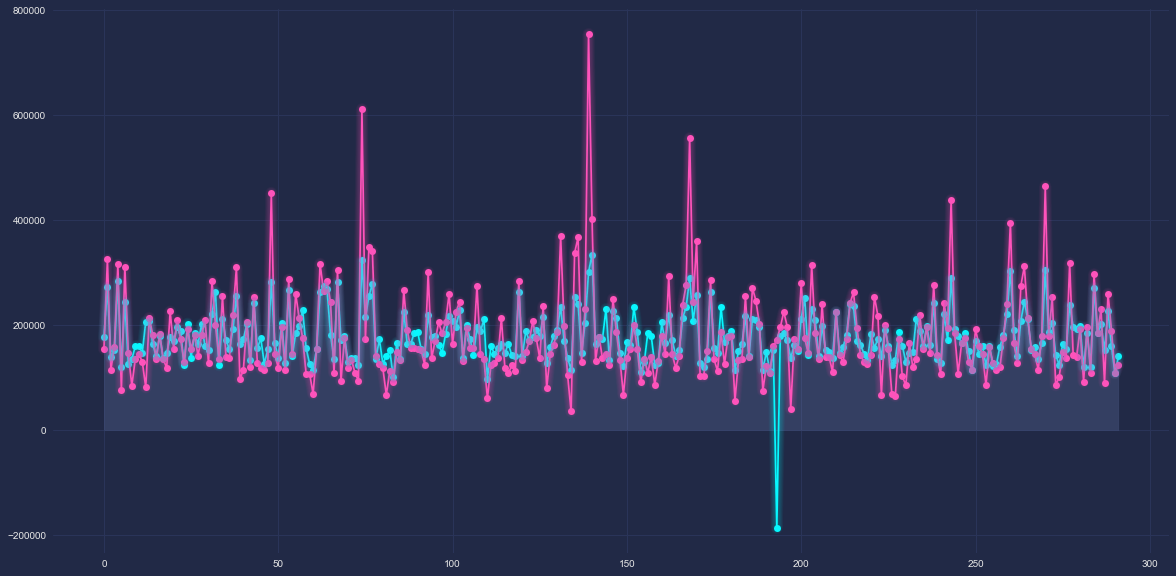

In [30]:
rcParams['figure.figsize'] = 20, 10

plt.plot(p, marker='o')
plt.plot(y_holdout.values, marker='o')

mplcyberpunk.add_glow_effects()

plt.show()

I am very curious about nature of this huge drop at the point.